Import Libraries and Load Data

In [1]:
import os
import numpy as np
import mido
from mido import MidiFile
from multiprocessing import Pool
import time
from mido import MidiFile
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation, Reshape, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# random seed for reproductibility
np.random.seed(42)


Load and Pre-process MIDI Data

In [2]:
import os
from music21 import converter, note, chord

def midi_to_notes(file_path):
    try:
        print(f"Processing file: {file_path}")
        midi = converter.parse(file_path)
        if not midi.parts:  # Check if there are any parts in the MIDI file
            print(f"Warning: No parts found in {file_path}")
            return []
        notes = []
        for part in midi.parts:
            notes_to_parse = part.recurse().notes
            for element in notes_to_parse:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))
        return notes
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return []

# Specify the directory containing the MIDI files
midi_directory = r'C:\Users\varshitha y r\Downloads\midis_v1.2\midis'

# Set the maximum number of files to process
max_files_to_process = 4
processed_files = 0

# Loop through each file in the directory
for filename in os.listdir(midi_directory):
    if filename.endswith('.midi') or filename.endswith('.mid'):
        file_path = os.path.join(midi_directory, filename)
        
        # Call the function with the file path
        notes = midi_to_notes(file_path)
        
        # Print the extracted notes (limit to top 5 notes)
        if notes:
            print(f"Top 5 notes from {filename}: {notes}")
        else:
            print(f"No notes extracted from {filename}.")
        
        # Increment the counter
        processed_files += 1
        
        # Stop after processing the desired number of files
        if processed_files >= max_files_to_process:
            break


Processing file: C:\Users\varshitha y r\Downloads\midis_v1.2\midis\A., Jag, Je t'aime Juliette, OXC7Fd0ZN8o.mid
Top 5 notes from A., Jag, Je t'aime Juliette, OXC7Fd0ZN8o.mid: ['9.0', '9.0', '9.0', 'E5', 'E5', 'A3', 'C3', '4.9', 'A5', 'C3', '4.9', 'E5', 'E3', 'A3', 'E5', 'E5', 'A5', '4.9', 'A3', 'A4', 'C6', 'A2', 'A6', 'E5', '11.2.4', 'A5', 'B3', 'A5', 'B3', 'E3', '11.2', '11.2', 'A5', 'A5', '5.11', '5.9', '5.11', '5.11', 'A5', '9.0', '4.9', '5.11', '5.11', '5.11', 'B3', 'D6', 'E5', '9.0', '9.0', 'B2', 'F5', '9.0', 'A6', '4.9', '4.9', '4.9', '4.9', 'A3', 'C6', 'A2', '11.2.4', 'B3', 'A5', 'A6', '4.9', 'E5', '11.2', '4.9', 'A6', 'A3', '9.0', '5.11', 'A5', '9.11.2', '4.9', 'F5', 'E3', 'B3', '5.11', 'B6', 'B3', 'F5', '5.11', 'B3', 'D6', '9.0', 'B2', 'F5', '4.9', 'D6', 'D6', '11.4', '11', '11', 'F5', '5.11', 'B5', 'F5', 'A5', 'B2', 'E5', 'F5', 'B3', 'F3', 'A5', '9.0', '9.0', 'A3', 'E5', 'E3', '4.9', 'E5', '9', 'A3', '5.11', 'F5', 'B3', '4.9', 'A3', 'E5', 'E5', '9.0', 'C6', 'B4', 'E3', '4.9',

Top 5 notes from Abel, Frederic, Lola Polka, SLNJF0uiqRw.mid: ['D4', 'D4', '7.11', '7.11', 'D4', '7.11', 'D4', 'G4', 'B4', 'D5', 'G4', 'B4', 'D5', 'G4', '2', '6.9.0', '2', '6.9.0', '7', 'B3', '4.7', 'B3', 'C5', '9', 'C5', 'E5', '2', '2', '2', '6.9.0', '8.11', '9.0', 'G2', '11.2.4', '10.1', 'D5', 'C5', '6.9.0.2', 'C5', '7.11.2', '7.11.2', 'B4', '9.0', 'E5', '2', 'D4', '6.9.0', 'C5', '6.9.0', 'E5', '7', 'D3', '2', '7', '11.2', '11.4', 'C5', '2', 'D5', 'B4', '11.2', '6.9.0.2', 'B4', 'G2', '7.11.2', '6.9.0', '9.0', 'G4', '7.11.2', 'C5', '2', '2', 'A4', '2', '7', 'D4', '11.4', '6.9.0', '6.9.0', '11.4', 'D5', '7', '2', '6.9.0', 'A4', 'C5', 'B3', '11.2.4.7', '10.11.1', '2', '6.9.0.2', '8.11', 'A4', '7.11.2', 'D5', '4.7', 'B4', 'C5', 'D5', '2', '6.9.0', 'G3', '2', '4.7', 'D4', '0.6', 'C5', 'G4', '11.4', 'D3', 'A4', 'A3', '11.2', '11.2', '6.9.0', '6.9.0.2', 'C5', 'G2', '7.11.2', 'D5', '9.0', 'B4', 'A4', 'G4', '7.11.2', 'A4', '4', '4.7.11', '4.7.11', '7.11', 'E3', '4.7.11', 'E5', 'E5', 'E2', '4.

In [1]:
import pygame
import os
import time

def play_midi(file_path, play_duration=5):
    try:
        # Initialize the mixer
        pygame.mixer.init()

        # Load and play the MIDI file
        pygame.mixer.music.load(file_path)
        pygame.mixer.music.play()

        # Record the start time
        start_time = time.time()
        
        # Wait until the music finishes playing or the duration has passed
        while pygame.mixer.music.get_busy():
            # Check if play_duration seconds have passed
            if time.time() - start_time >= play_duration:
                pygame.mixer.music.stop()
            pygame.time.Clock().tick(10)
    except Exception as e:
        print(f"Error playing {file_path}: {e}")
    finally:
        pygame.mixer.quit()

# Specify the directory containing the MIDI files
midi_directory = r'C:\Users\varshitha y r\Downloads\midis_v1.2\midis'

# Set the maximum number of files to process
max_files_to_process = 10
processed_files = 0

# Loop through each file in the directory
for filename in os.listdir(midi_directory):
    if filename.endswith('.midi') or filename.endswith('.mid'):
        file_path = os.path.join(midi_directory, filename)
        
        # Play the MIDI file for 5 seconds
        print(f"Playing file: {file_path}")
        play_midi(file_path, play_duration=5)
        
        # Increment the counter
        processed_files += 1
        
        # Stop after processing the desired number of files
        if processed_files >= max_files_to_process:
            break


pygame 2.6.0 (SDL 2.28.4, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html
Playing file: C:\Users\varshitha y r\Downloads\midis_v1.2\midis\A., Jag, Je t'aime Juliette, OXC7Fd0ZN8o.mid
Playing file: C:\Users\varshitha y r\Downloads\midis_v1.2\midis\Aaron, Michael, Piano Course, V8WvKK-1b2c.mid
Playing file: C:\Users\varshitha y r\Downloads\midis_v1.2\midis\Abel, Frederic, Lola Polka, SLNJF0uiqRw.mid


KeyboardInterrupt: 

Prepare Data for Model Training
--Creating Sequences of Notes:

In [4]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Define a function to create sequences and next note targets
def create_sequences(notes, sequence_length=100):
    sequences = []
    next_notes = []
    
    # Create a mapping of unique notes to integers
    unique_notes = sorted(set(notes))
    note_to_int = {note: number for number, note in enumerate(unique_notes)}
    
    # Create sequences and their corresponding next notes
    for i in range(len(notes) - sequence_length):
        sequence = notes[i:i + sequence_length]
        next_note = notes[i + sequence_length]
        sequences.append([note_to_int[note] for note in sequence])
        next_notes.append(note_to_int[next_note])
    
    return sequences, next_notes, unique_notes

# Example usage with all notes from processed MIDI files
all_notes = []
midi_directory = r'C:\Users\varshitha y r\Downloads\midis_v1.2\midis'


processed_count = 0
max_files = 130

for filename in os.listdir(midi_directory):
    if processed_count >= max_files:
        break
    if filename.endswith('.midi') or filename.endswith('.mid'):
        file_path = os.path.join(midi_directory, filename)
        notes = midi_to_notes(file_path)
        if notes:
            all_notes.extend(notes)
        processed_count += 1

# Create sequences
sequence_length = 100  #for each 100 notes we generate the next note as the target note
sequences, next_notes, unique_notes = create_sequences(all_notes, sequence_length)
#we transform list of notes to sequences of 100 notes with the 101th note as target. 

# Convert sequences and next_notes to numpy arrays
X = np.array(sequences)
y = np.array(next_notes)

# One-hot encode the output variable
y = to_categorical(y, num_classes=len(unique_notes))

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


Processing file: C:\Users\varshitha y r\Downloads\midis_v1.2\midis\A., Jag, Je t'aime Juliette, OXC7Fd0ZN8o.mid
Processing file: C:\Users\varshitha y r\Downloads\midis_v1.2\midis\Aaron, Michael, Piano Course, V8WvKK-1b2c.mid
Processing file: C:\Users\varshitha y r\Downloads\midis_v1.2\midis\Abel, Frederic, Lola Polka, SLNJF0uiqRw.mid
Processing file: C:\Users\varshitha y r\Downloads\midis_v1.2\midis\Abramowitsch, A., 3 Nocturnes, LKK-7L2Ppw8.mid
Processing file: C:\Users\varshitha y r\Downloads\midis_v1.2\midis\Abreu, Zequinha, Tico-Tico no fubá, KyEuFpJuwfc.mid
Processing file: C:\Users\varshitha y r\Downloads\midis_v1.2\midis\Abt, Franz, 7 Lieder aus dem Buche der Liebe, Op.39, K33a_r6IKeA.mid
Processing file: C:\Users\varshitha y r\Downloads\midis_v1.2\midis\Achron, Joseph, 2 Pieces, Op.56, sNqKnJNxSOE.mid
Processing file: C:\Users\varshitha y r\Downloads\midis_v1.2\midis\Achron, Joseph, Symphonic Variations and Sonata, Op.39, RtRrQwO2Hng.mid
Processing file: C:\Users\varshitha y r\

In [6]:

#Limit the Number of Files Processed
max_files_to_process = 140  # Set a maximum number of files to process
processed_files = 0

for filename in os.listdir(midi_directory):
    if filename.endswith('.midi') or filename.endswith('.mid'):
        file_path = os.path.join(midi_directory, filename)
        notes = midi_to_notes(file_path)
        if notes:
            all_notes.extend(notes)
        
        processed_files += 1
        if processed_files >= max_files_to_process:
            break


Processing file: C:\Users\varshitha y r\Downloads\midis_v1.2\midis\A., Jag, Je t'aime Juliette, OXC7Fd0ZN8o.mid
Processing file: C:\Users\varshitha y r\Downloads\midis_v1.2\midis\Aaron, Michael, Piano Course, V8WvKK-1b2c.mid
Processing file: C:\Users\varshitha y r\Downloads\midis_v1.2\midis\Abel, Frederic, Lola Polka, SLNJF0uiqRw.mid
Processing file: C:\Users\varshitha y r\Downloads\midis_v1.2\midis\Abramowitsch, A., 3 Nocturnes, LKK-7L2Ppw8.mid
Processing file: C:\Users\varshitha y r\Downloads\midis_v1.2\midis\Abreu, Zequinha, Tico-Tico no fubá, KyEuFpJuwfc.mid
Processing file: C:\Users\varshitha y r\Downloads\midis_v1.2\midis\Abt, Franz, 7 Lieder aus dem Buche der Liebe, Op.39, K33a_r6IKeA.mid
Processing file: C:\Users\varshitha y r\Downloads\midis_v1.2\midis\Achron, Joseph, 2 Pieces, Op.56, sNqKnJNxSOE.mid
Processing file: C:\Users\varshitha y r\Downloads\midis_v1.2\midis\Achron, Joseph, Symphonic Variations and Sonata, Op.39, RtRrQwO2Hng.mid
Processing file: C:\Users\varshitha y r\

In [7]:
#Preprocess and Save Intermediate Data
import pickle

# Save preprocessed notes to a file
with open('preprocessed_notes.pkl', 'wb') as f:
    pickle.dump(all_notes, f)

# Later, you can load the notes back
with open('preprocessed_notes.pkl', 'rb') as f:
    all_notes = pickle.load(f)


Encoding and Reshaping:

In [9]:
# Reshape input to be compatible with LSTM layers
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

# Normalize input data to have values between 0 and 1
X_train = X_train / float(len(unique_notes))
X_val = X_val / float(len(unique_notes))


Define the GAN Model Architecture

Build the Generator and Discriminator Models

In [10]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, Reshape
from keras.optimizers import Adam

# Generator model
def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(100))
    model.add(Activation('tanh'))
    model.add(Reshape((100, 1)))  # Reshape to match the output shape expected by the discriminator
    return model

# Discriminator model
def build_discriminator():
    model = Sequential()
    model.add(LSTM(256, input_shape=(100, 1), return_sequences=True))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model



Compile the Combined Model (GAN)

In [11]:
# Build and compile models
latent_dim = 100
generator = build_generator()
discriminator = build_discriminator()

# Combined GAN model
def build_combined(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

combined = build_combined(generator, discriminator)


Train the GAN

In [12]:
batch_size = 32
epochs = 1000

# Training loop for the GAN
for epoch in range(epochs):
    # Generate random noise as input for the generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generated_sequences = generator.predict(noise)

    # Select a random batch of real sequences
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_sequences = X_train[idx]

    # Create labels for real and fake data
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_sequences, real_labels)
    d_loss_fake = discriminator.train_on_batch(generated_sequences, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    valid_y = np.ones((batch_size, 1))
    g_loss = combined.train_on_batch(noise, valid_y)

    # Print progress
    print(f"Epoch {epoch + 1}/{epochs} [D loss: {d_loss[0]} | D accuracy: {d_loss[1]}] [G loss: {g_loss}]")

    # Save models periodically
    if epoch % 100 == 0:
        generator.save(f"generator_epoch_{epoch + 1}.h5")
        discriminator.save(f"discriminator_epoch_{epoch + 1}.h5")
        np.save(f"generated_sequences_epoch_{epoch + 1}.npy", generated_sequences) #save generated sequence of every 100 epochs

# Save final models
generator.save("final_generator.h5")
discriminator.save("final_discriminator.h5")


1/1 [==============================] - 1s 1s/step
Epoch 1/1000 [D loss: 0.7069155871868134 | D accuracy: 0.078125] [G loss: 0.6905615329742432]


C:\Users\varshitha y r\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 29ms/step
Epoch 2/1000 [D loss: 0.675047367811203 | D accuracy: 0.734375] [G loss: 0.6954484581947327]
1/1 [==============================] - 0s 31ms/step
Epoch 3/1000 [D loss: 0.6498816907405853 | D accuracy: 0.78125] [G loss: 0.6925428509712219]
1/1 [==============================] - 0s 27ms/step
Epoch 4/1000 [D loss: 0.620173990726471 | D accuracy: 0.640625] [G loss: 0.6887771487236023]
1/1 [==============================] - 0s 45ms/step
Epoch 5/1000 [D loss: 0.5854271650314331 | D accuracy: 0.65625] [G loss: 0.6651098728179932]
1/1 [==============================] - 0s 27ms/step
Epoch 6/1000 [D loss: 0.5371376276016235 | D accuracy: 0.65625] [G loss: 0.6572030782699585]
1/1 [==============================] - 0s 39ms/step
Epoch 7/1000 [D loss: 0.4986776262521744 | D accuracy: 0.546875] [G loss: 0.6368057727813721]
1/1 [==============================] - 0s 25ms/step
Epoch 8/1000 [D loss: 0.48512178286910057 | D accuracy: 0.53125] [G loss: 0.6

Generate and Save MIDI Files from the Generator

In [14]:
from mido import Message, MidiFile, MidiTrack
import numpy as np

def convert_sequence_to_midi(sequence, output_path):
    mid = MidiFile()  # Create a new MIDI file
    track = MidiTrack()  # Create a new track
    mid.tracks.append(track)

    for note in sequence.flatten():  # Flatten sequence if needed
        # Ensure the note value is within the valid MIDI range
        midi_note = int(note * 127)  # Scale the note to MIDI range if necessary
        midi_note = max(0, min(127, midi_note))  # Clamp the value between 0 and 127
        
        #note on and note off events
        track.append(Message('note_on', note=midi_note, velocity=64, time=0))
        track.append(Message('note_off', note=midi_note, velocity=64, time=200))  # Adjust time as needed

    mid.save(output_path)  # Save the MIDI file

# Generate new sequences
latent_dim = 100  # Example latent dimension, adjust as per your model's configuration
noise = np.random.normal(0, 1, (10, latent_dim))  # Generate 10 new sequences
generated_sequences = generator.predict(noise)

# Convert generated sequences to MIDI and save
for i, sequence in enumerate(generated_sequences):
    output_path = f'generated_sequence_{i}.midi'
    convert_sequence_to_midi(sequence, output_path)
    print(f"Saved MIDI file: {output_path}")


1/1 [==============================] - 0s 40ms/step
Saved MIDI file: generated_sequence_0.midi
Saved MIDI file: generated_sequence_1.midi
Saved MIDI file: generated_sequence_2.midi
Saved MIDI file: generated_sequence_3.midi
Saved MIDI file: generated_sequence_4.midi
Saved MIDI file: generated_sequence_5.midi
Saved MIDI file: generated_sequence_6.midi
Saved MIDI file: generated_sequence_7.midi
Saved MIDI file: generated_sequence_8.midi
Saved MIDI file: generated_sequence_9.midi


In [15]:
import numpy as np

#  Saving a NumPy array
generated_sequences = np.random.randn(10, 100)  # Example array
np.save('generated_sequences_epoch_1.npy', generated_sequences)

#  Loading the NumPy array
loaded_sequences = np.load('generated_sequences_epoch_1.npy')
print(loaded_sequences)


[[ 8.15054679e-01  1.92744725e+00 -7.39447272e-01  7.52436615e-01
   6.15554956e-01  2.11060030e-01  8.41963574e-02  1.95220758e+00
  -1.07096217e+00 -2.76647234e-01  8.63022223e-01  2.82147397e-01
  -5.14476787e-01  9.77271682e-01  3.55369690e-01 -5.81205718e-01
   5.81947714e-01  4.89519943e-01  9.94427689e-01 -6.22109050e-01
   8.22339916e-01  1.00892120e+00  4.11111579e-01  1.86791108e-01
  -9.36440562e-02  1.10928526e+00 -5.12246087e-01 -2.68385257e-01
   1.73263818e+00 -1.70925528e+00 -3.51878949e-01 -5.56266278e-01
   2.07620196e+00 -7.70271141e-01  9.31481813e-01  1.07540712e-02
   6.65279142e-01 -2.75699921e-01 -5.93766063e-01 -6.24977843e-01
  -5.08653025e-01 -9.04222203e-01 -1.65688443e-01  1.20746856e+00
   2.12371747e+00 -4.96595615e-01  9.52500009e-02 -4.89940853e-01
   6.06960774e-01  1.54944272e+00  6.50286667e-01 -5.05530401e-01
   2.80614223e+00 -1.74562691e+00 -1.41681253e+00 -4.18417858e-01
  -2.96118265e-01  1.12824082e+00 -3.11616925e-01  8.97017173e-01
   4.12521

Load and Parse the Generated MIDI Files:

In [16]:
from music21 import converter, instrument, note, chord

# Function to parse and display the MIDI file content
def display_midi_content(file_path):
    # Load the MIDI file
    midi = converter.parse(file_path)
    
    # Display the instruments
    parts = instrument.partitionByInstrument(midi)
    
    # Iterate through each note in each part
    for part in parts.parts:
        print(f"Instrument: {part.partName}")
        notes_to_parse = part.recurse().notes
        for element in notes_to_parse:
            if isinstance(element, note.Note):
                print(f"Note: {element.pitch}")
            elif isinstance(element, chord.Chord):
                print(f"Chord: {' '.join(str(n) for n in element.normalOrder)}")

# Example: Display the content of a generated MIDI file
midi_file_path = 'generated_sequence_0.midi'
display_midi_content(midi_file_path)


Instrument: None
Note: D6
Note: B5
Note: G8
Note: E-3
Note: E-3
Note: A8
Note: A7
Note: C4
Note: B0
Note: C0
Note: C0
Note: E-7
Note: E-0
Note: C-1
Note: B-8
Note: F7
Note: C7
Note: F#1
Note: E-7
Note: F#7
Note: F#8
Note: F8
Note: F#9
Note: B-8
Note: F#5
Note: E6
Note: F9
Note: E8
Note: F9
Note: E8
Note: C1
Note: E8
Note: G#2
Note: C#8
Note: A8
Note: F8
Note: C9
Note: B-7
Note: E6
Note: B6
Note: G#8
Note: G#8
Note: B-8
Note: F6
Note: D9
Note: E-9
Note: E8
Note: C8
Note: C#1
Note: B-8
Note: B5
Note: B2
Note: G#7
Note: G#7
Note: D9
Note: D6
Note: C7
Note: C9
Note: F#3
Note: B-8
Note: B-5
Note: B-5
Note: E-7
Note: A7
Note: E8
Note: B-8
Note: A5
Note: D5
Note: C#5
Note: D3
Note: A8
Note: A7
Note: B3
Note: E6
Note: G#5
Note: E9
Note: C7
Note: B-8
Note: G4
Note: A7
Note: E7
Note: B7
Note: E7
Note: E-0
Note: F#7
Note: E7
Note: B6
Note: E9
Note: D7
Note: B8
Note: G#6
Note: E5
Note: E5
Note: D5
Note: F6
Note: B-7
Note: A6
Note: C-1
Note: A8
Note: E-7
Note: A7
Note: F#8
Note: E-8
Note: A7
Note: 

Visualize Note Distributions or Piano Roll

# Visual overview of distribution of notes in MIDI sequence and how long each note lasts

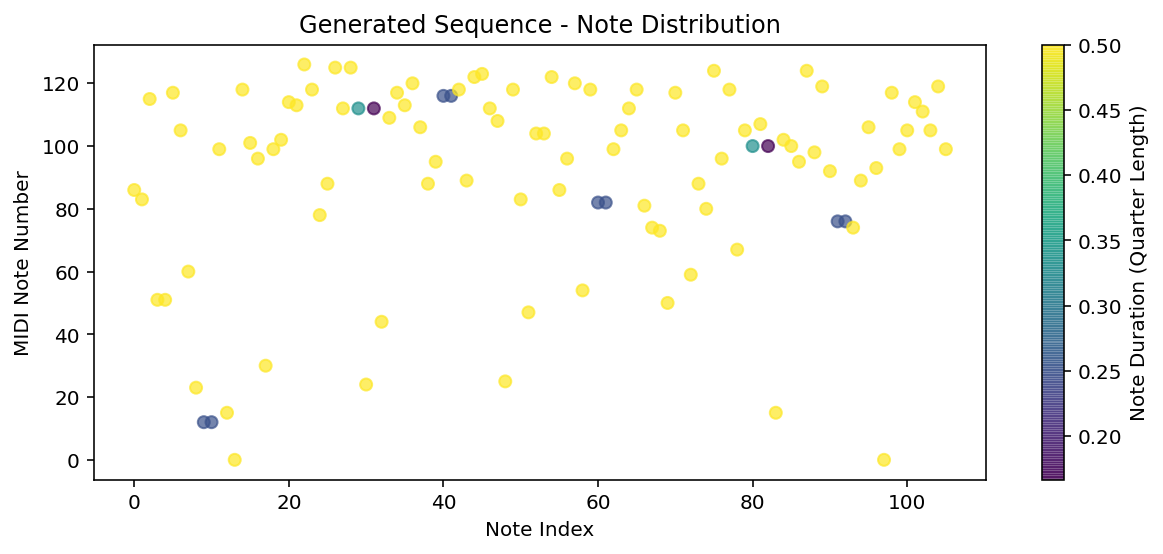

In [17]:
import matplotlib.pyplot as plt

def plot_midi_notes(midi_file_path):
    midi = converter.parse(midi_file_path)
    notes_to_parse = None
    parts = instrument.partitionByInstrument(midi)

    for part in parts.parts:
        notes_to_parse = part.recurse().notes
        break  # Consider only the first instrument part

    notes = []
    durations = []

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(element.pitch.midi)
            durations.append(element.quarterLength)
        elif isinstance(element, chord.Chord):
            notes.append(element.root().midi)
            durations.append(element.quarterLength)

    plt.figure(figsize=(10, 4))
    plt.scatter(range(len(notes)), notes, c=durations, cmap='viridis', alpha=0.7)
    plt.colorbar(label='Note Duration (Quarter Length)')
    plt.xlabel('Note Index')
    plt.ylabel('MIDI Note Number')
    plt.title('Generated Sequence - Note Distribution')
    plt.show()

# Example usage
plot_midi_notes(midi_file_path)


Quantitative evaluation

In [2]:
import pygame
import time

# Initialize Pygame mixer
pygame.mixer.init()

# Load the generated MIDI file
midi_file_path = 'generated_sequence_0.midi'  # Replace with your generated MIDI file path
try:
    pygame.mixer.music.load(midi_file_path)
    print(f"Playing {midi_file_path}...")

    # Play the MIDI file
    pygame.mixer.music.play()

    # Wait until the MIDI file is done playing
    while pygame.mixer.music.get_busy():
        time.sleep(1)

except pygame.error as e:
    print(f"Could not play MIDI file: {e}")

finally:
    # Clean up the mixer
    pygame.mixer.quit()


Playing generated_sequence_0.midi...


In [6]:
import pygame
import time

# Initialize Pygame mixer
pygame.mixer.init()

# Load the generated MIDI file
midi_file_path = 'generated_sequence_1.midi'  
try:
    pygame.mixer.music.load(midi_file_path)
    print(f"Playing {midi_file_path}...")

    # Play the MIDI file
    pygame.mixer.music.play()

    # Wait until the MIDI file is done playing
    while pygame.mixer.music.get_busy():
        time.sleep(1)

except pygame.error as e:
    print(f"Could not play MIDI file: {e}")

finally:
    # Clean up the mixer
    pygame.mixer.quit()


Playing generated_sequence_1.midi...


1/1 [==============================] - 0s 22ms/step


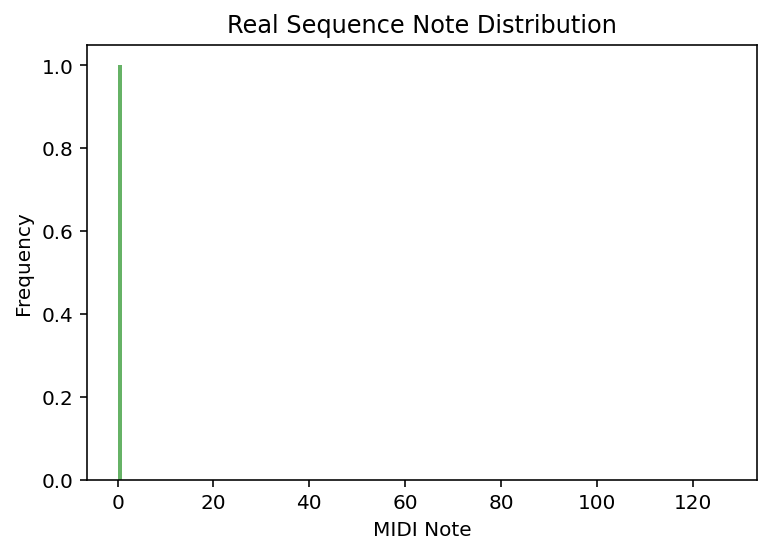

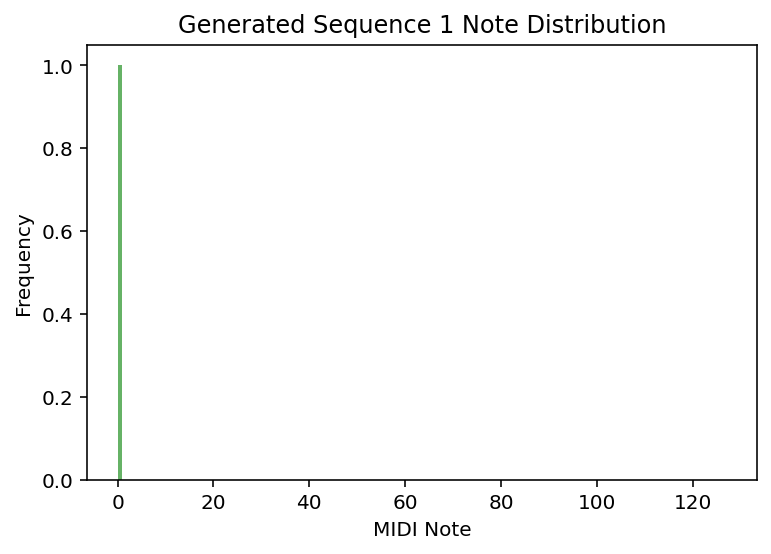

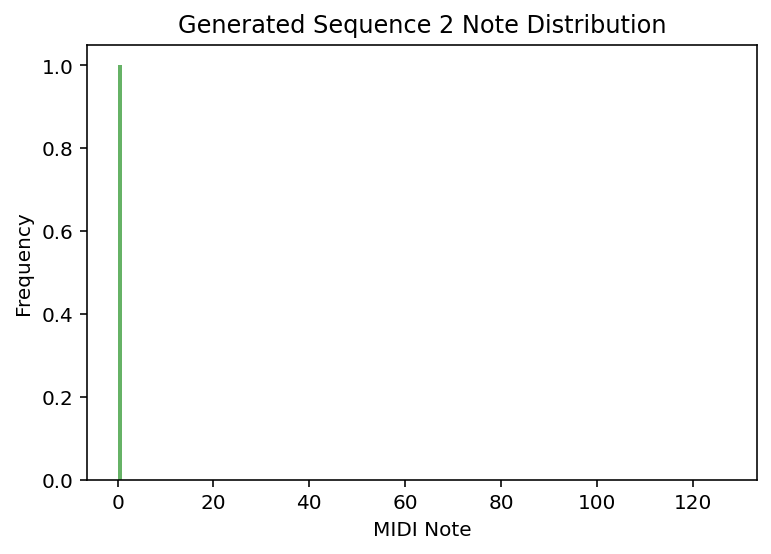

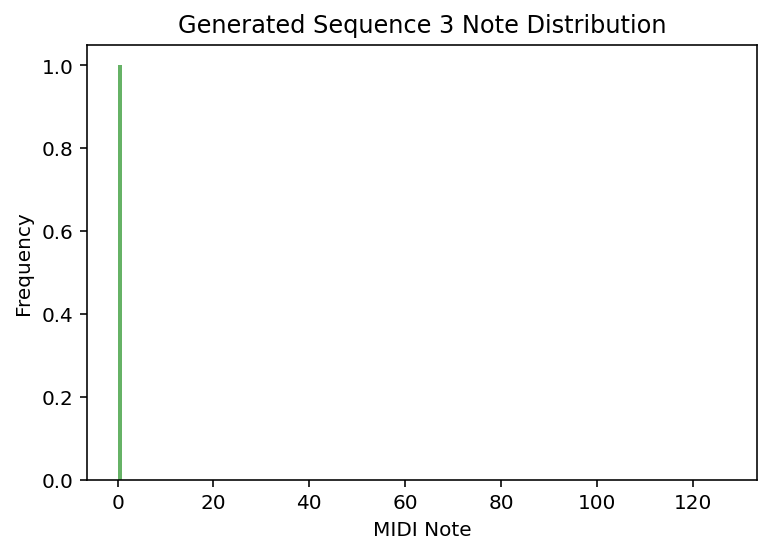

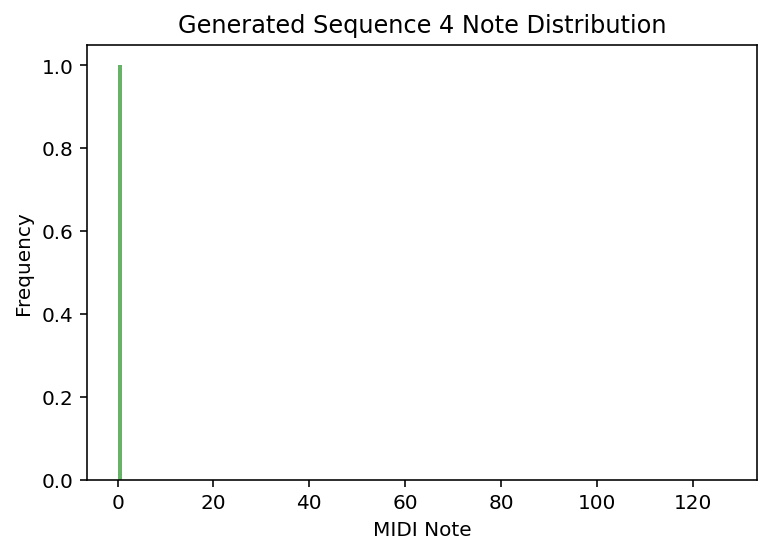

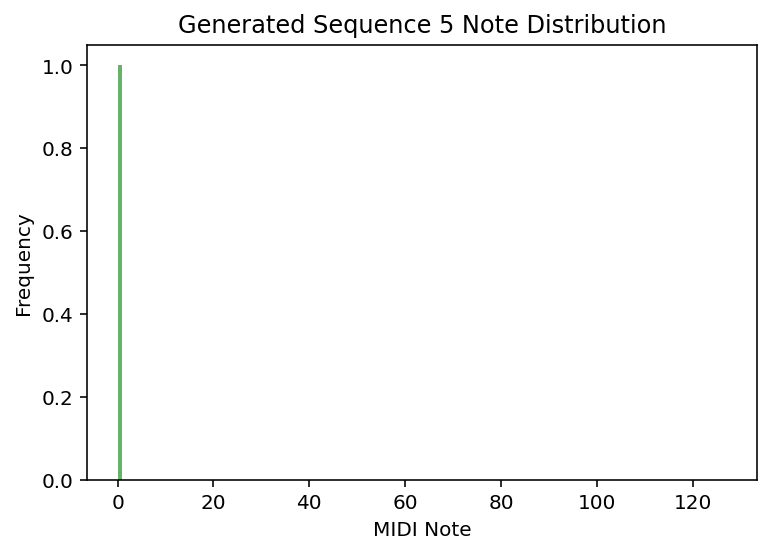

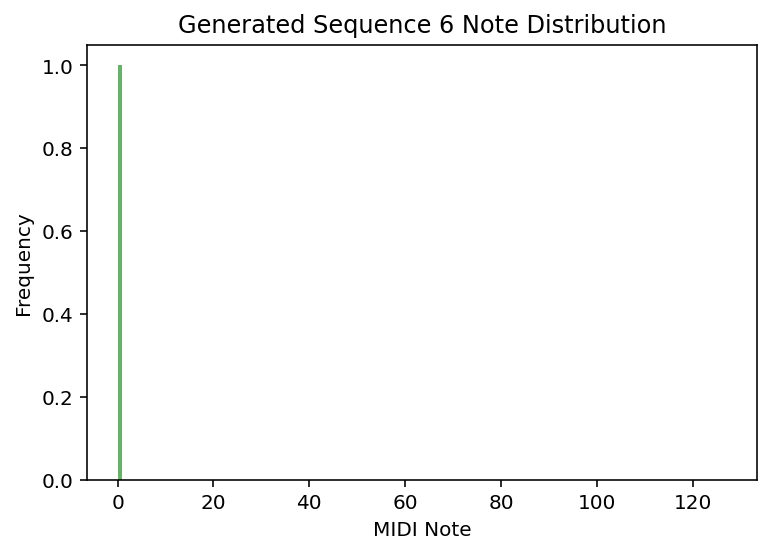

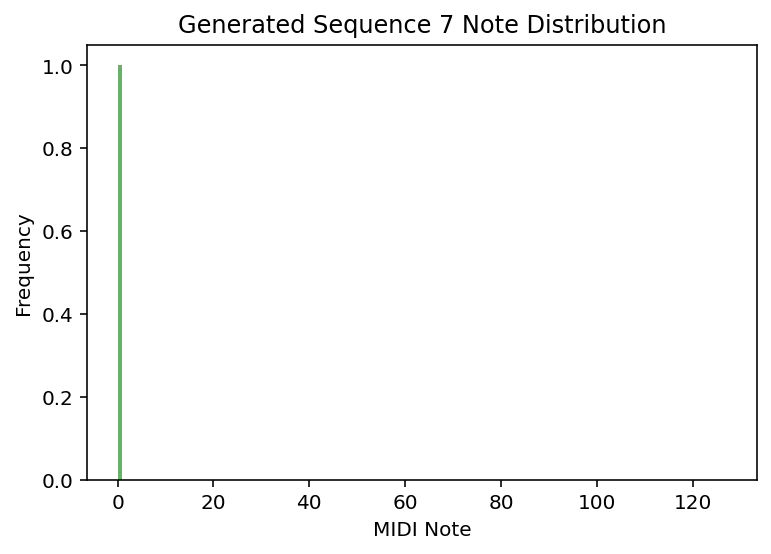

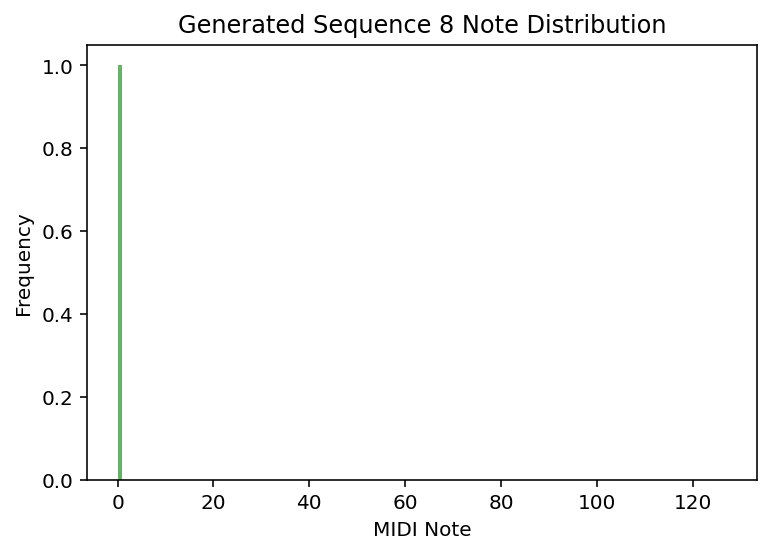

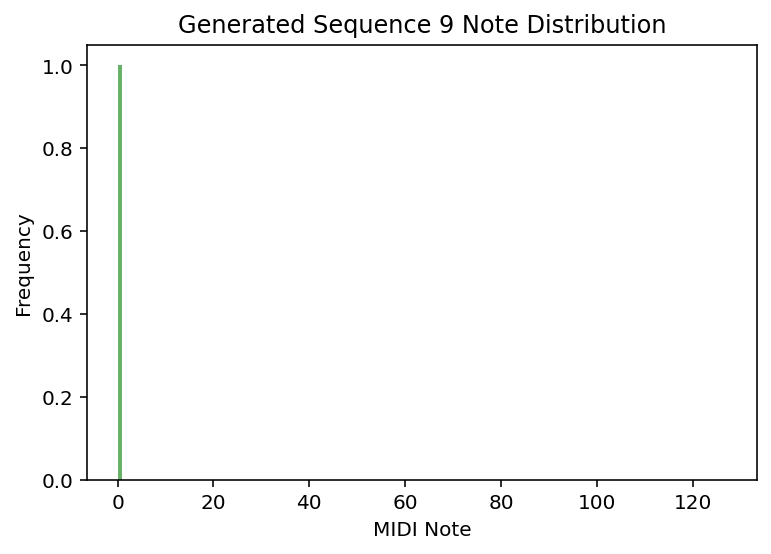

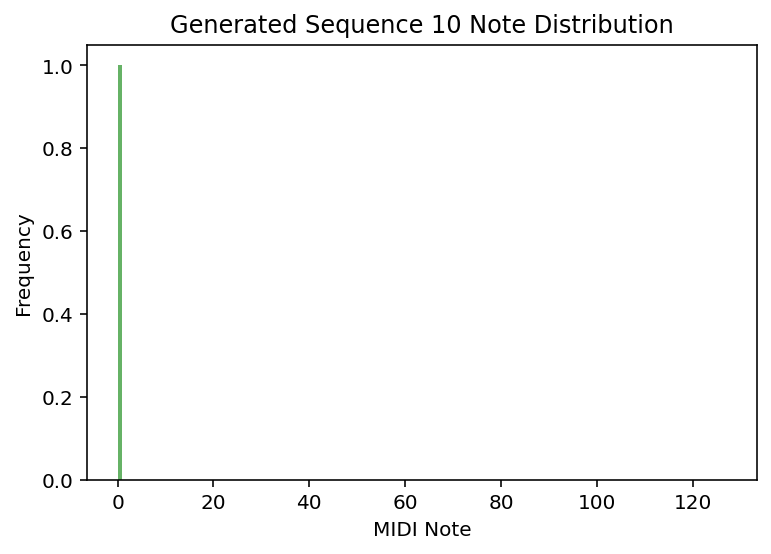

In [20]:
# Load your generator model and some real data
real_sample_idx = np.random.randint(0, X_train.shape[0], 1)[0]
real_sequence = X_train[real_sample_idx].flatten()

# Generate new sequences for evaluation
noise = np.random.normal(0, 1, (10, latent_dim))
generated_sequences = generator.predict(noise)

# Plot distributions of notes in real and generated sequences
plot_note_distribution(real_sequence, title="Real Sequence Note Distribution")
for i, gen_seq in enumerate(generated_sequences):
    plot_note_distribution(gen_seq.flatten(), title=f"Generated Sequence {i+1} Note Distribution")
